
# **Stock Price Prediction using Machine Learning in Python**


## Import libraries and Data set

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve

import warnings
warnings.filterwarnings('ignore')
# Grafiklerin daha güzel görünmesi için stil ayarları
sns.set(style='whitegrid')
%matplotlib inline


In [3]:
#Veri setini buraya yükleyelim
df = pd.read_csv('/content/drive/MyDrive/tesla_data.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


## **Keşifsel Veri Analizi (EDA)**
###Veri Setinin Genel Yapısını İnceleme

Veri setinin boyutunu, sütun isimlerini ve veri tiplerini incelenmesi

In [ ]:
# Veri setinin boyutu
print("Veri setinin boyutu:", df.shape)

Veri setinin boyutu: (2956, 7)


In [ ]:
# Sütun isimleri
print("Sütun isimleri:", df.columns.tolist())

Sütun isimleri: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [ ]:
#Veri tipleri ve eksik olmayan değerler
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


Tekrarlı(Duplicate) verilerin kontrolü

In [ ]:
duplicates = df[df.duplicated()]

if not duplicates.empty:
    print("DataFrame'de tekrarlanan veriler:")
    print(duplicates)
else:
    print("DataFrame'de tekrarlanan veri yok.")

DataFrame'de tekrarlanan veri yok.


Veri Seti incelendiğinde Close ve Adj Close değişkenlerinin aynı değerlere sahip olduğunu görüyoruz.Konrol edelim:

In [ ]:
df[df['Close'] == df['Adj Close']].shape


(2956, 7)

Buradan 'Close' ve 'Adj Close' sütunlarının tüm satırlarının aynı veriye sahip olduğu sonucuna varabiliriz. Bu nedenle, veri setinde gereksiz veri olması yardımcı olmayacaktır.Data pre-processing adımında bu sütunu sileceğiz.

###Missing Data Analysis
Finding the number and proportion of missing values ​​in each column

In [ ]:
missing_values_count = df.isnull().sum()

print(missing_values_count)

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


####Sütunların İstatistiksel Özellikleri


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2956.000000,2956.000000,2956.000000,2956.000000,2956.000000,2.956000e+03
mean,138.691296,141.771603,135.425953,138.762183,138.762183,3.131449e+07
std,250.044839,255.863239,243.774157,250.123115,250.123115,2.798383e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,19.627000,20.402000,19.127500,19.615000,19.615000,1.310288e+07
50%,46.656999,47.487001,45.820002,46.545000,46.545000,2.488680e+07
75%,68.057001,69.357500,66.911501,68.103998,68.103998,3.973875e+07
max,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,3.046940e+08


### Veri Dağılımlarının İncelenmesi

Tesla Hisse Senedi Fiyat verilerinin EDA'sını gerçekleştirirken, hisse senedi fiyatlarının zaman içinde nasıl hareket ettiğini ve çeyrek sonlarının hisse senedi fiyatlarını nasıl etkilediğini analiz edeceğiz.
Ayrıca:
1. Tesla Hisse fiyatlarının zaman içindeki değişimleri
2. Değişkenlerin Dağılımları
3. Outlier değerler var mı?


**1. Tesla Hisse fiyatlarının zaman içindeki değişimleri**


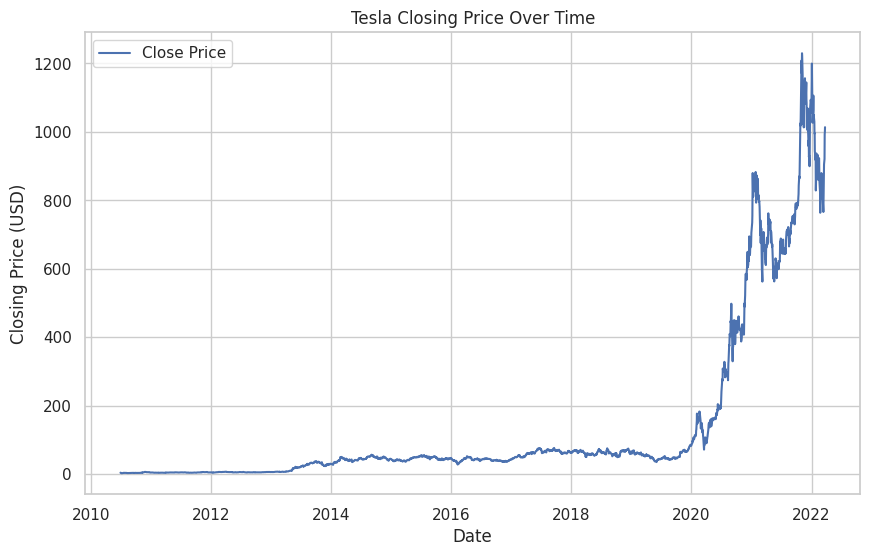

In [ ]:
df['Date'] = pd.to_datetime(df['Date']) #Date veri sütununu string-> tarih formatına çevirildi
plt.figure(figsize=(10, 6))
plt.plot(df['Date'],df['Close'], label='Close Price')
plt.title('Tesla Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

Tesla hisselerinin fiyatları, hisselerin kapanış fiyatının grafiğinden de görülebileceği gibi ***yükseliş eğilimi*** göstermektedir.




**2. Sürekli Değişkenlerin Dağılımları**

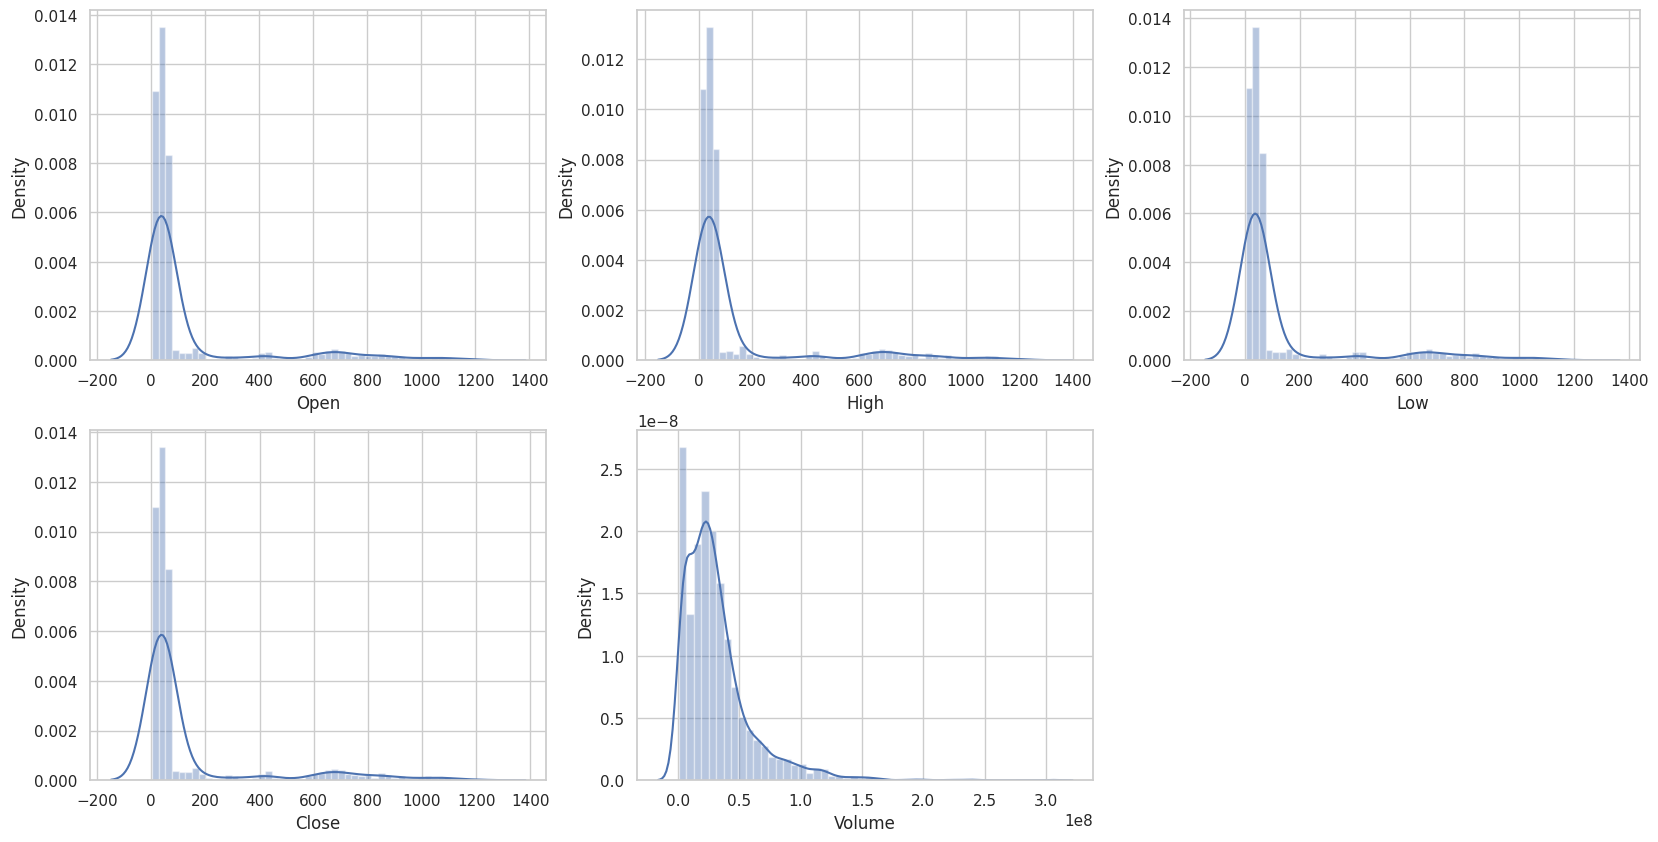

In [ ]:
#Yoğunluk(Density Plot) Grafiği:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(df[col])
plt.show()


* **Çan Eğrisi (Normal Dağılım)**: Tüm grafiklerde belirgin bir çan eğrisi gözlemlenmektedir. Bu, verilerin normal dağılıma yakın olduğunu gösterir. Ancak, özellikle "Volume" değişkeninde hafif bir sağa çarpıklık (pozitif skew) olduğu söylenebilir. Bu da, yüksek hacimli işlemlerin daha sık gözlemlendiğini ifade eder.
* **Merkezi Eğilim:** Tüm değişkenlerin ortalama değerleri sıfıra yakın bir bölgede yoğunlaşmış gibi görünmektedir. Bu, verilerin genel olarak sıfır civarında toplandığını gösterir. Ancak, bu durumun nedeni hakkında daha fazla bilgiye ihtiyaç vardır.
* **Dağılım:** "Open", "High", "Low" ve "Close" değişkenlerinin dağılımları birbirine oldukça benzerdir. Bu, bu değişkenlerin birbirleriyle yüksek korelasyonlu olduğunu düşündürür. "Volume" değişkeninin dağılımı ise diğerlerine göre daha geniştir, bu da hacimde daha fazla değişkenlik olduğunu gösterir.
* **Aykırı Değerler:** Grafiklerde belirgin aykırı değerler gözlemlenmemektedir. Bu, verilerin temiz ve tutarlı olduğunu düşündürür. Ancak, daha detaylı bir analiz için istatistiksel testler yapılabilir.


> **Değişkenlere Özel Yorumlar**
* **Open, High, Low, Close:** Bu fiyat verilerinin benzer dağılıma sahip olması, finansal piyasalarda fiyatların genellikle küçük hareketlerle değiştiğini ve büyük sıçramaların nadir olduğunu gösterir.
* **Volume:** Hacim verisinin sağa çarpıklığı, piyasada genellikle düşük hacimli işlemlerin olduğu, ancak zaman zaman yüksek hacimli işlemlerin de gerçekleştiğini gösterir.




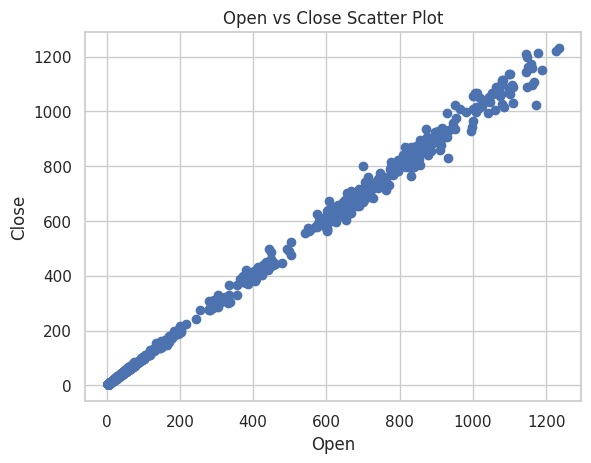

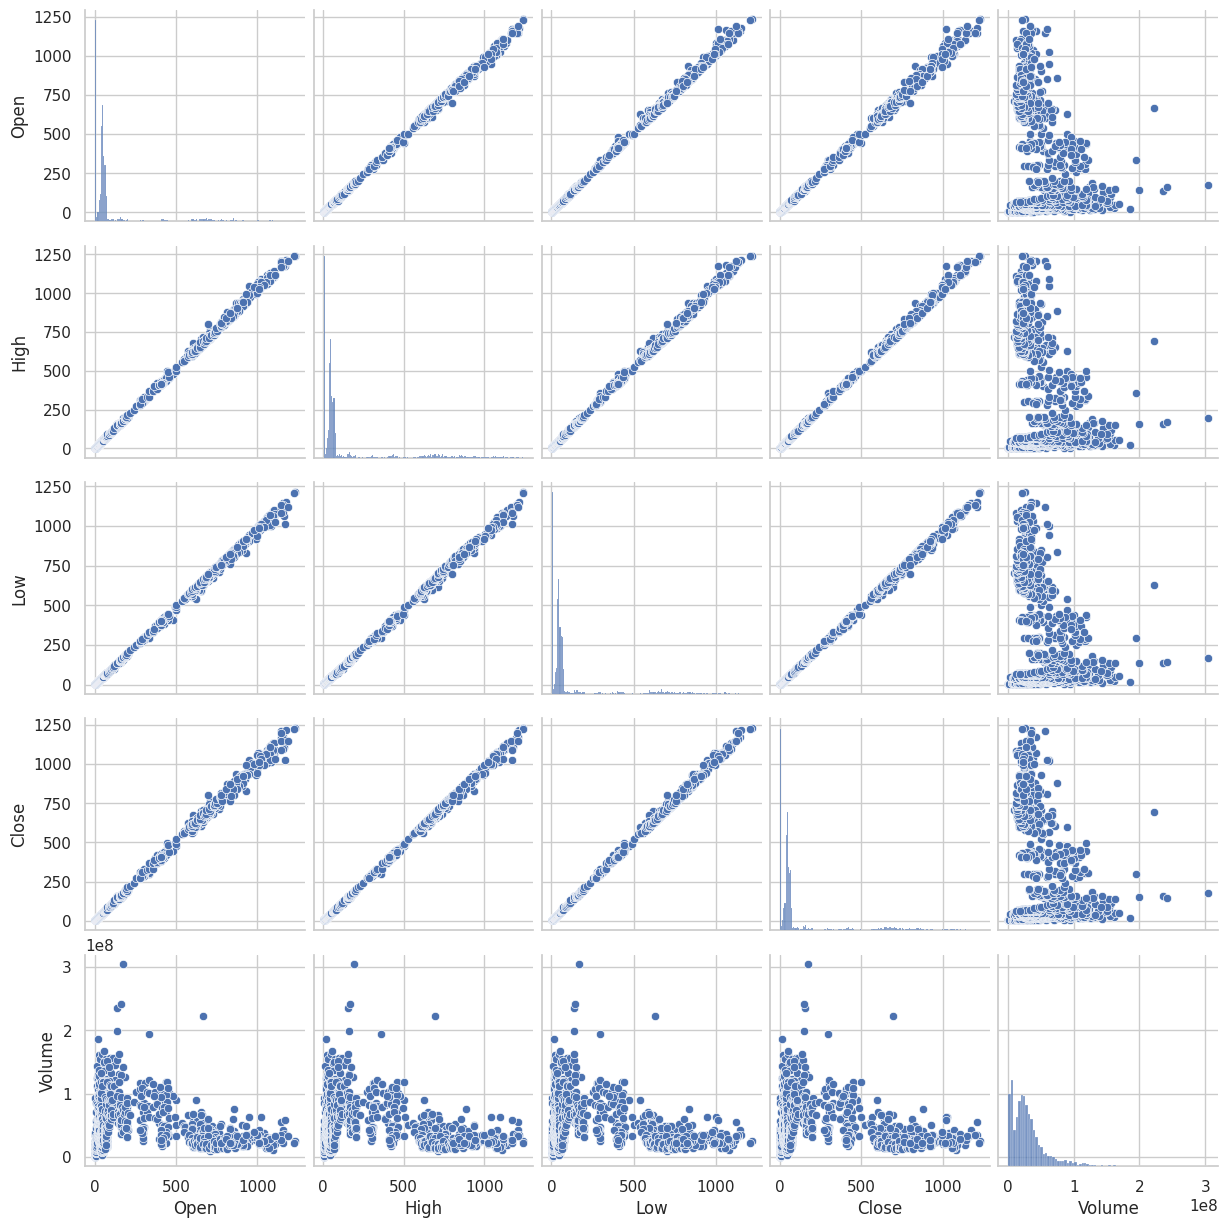

In [ ]:
# Scatter plot
plt.scatter(df['Open'], df['Close'])
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('Open vs Close Scatter Plot')
plt.show()

# Pairplot
sns.pairplot(df[features])
plt.show()


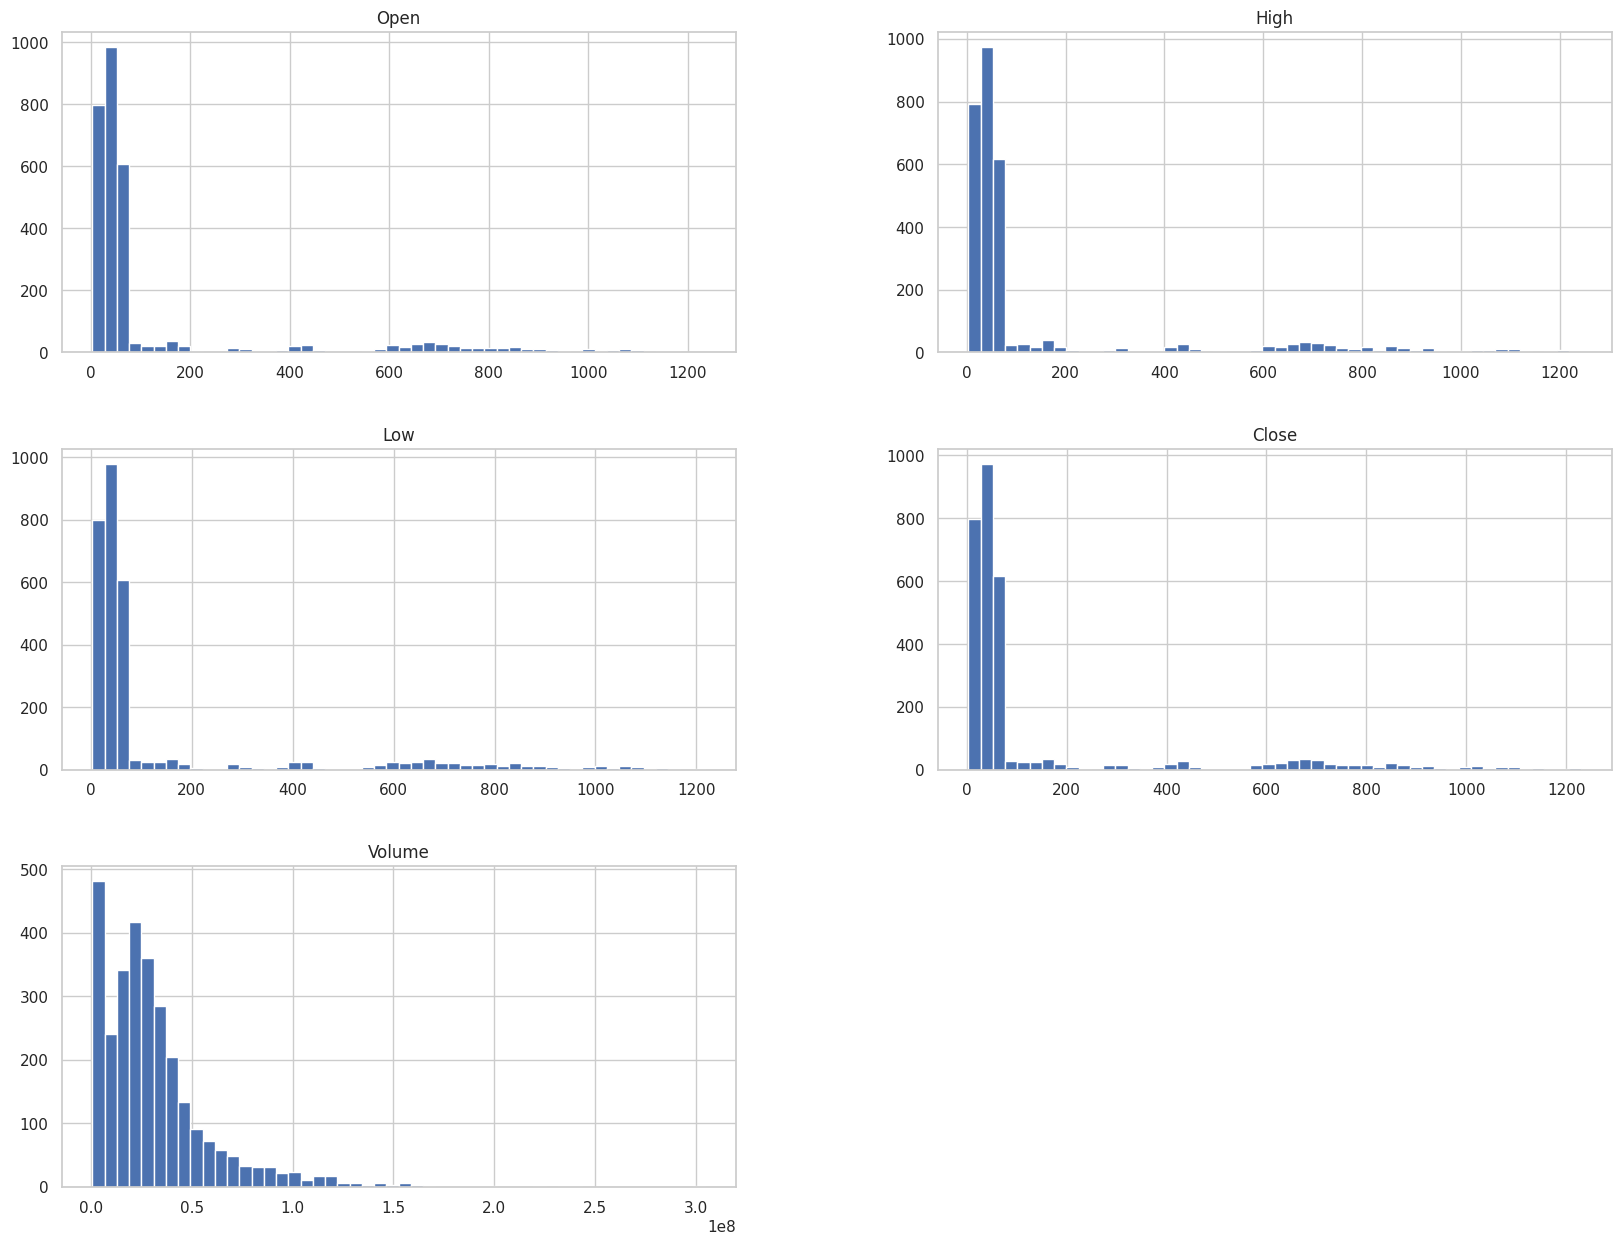

In [ ]:
#Histogram
df[features].hist(bins=50, figsize=(20, 15))
plt.show()


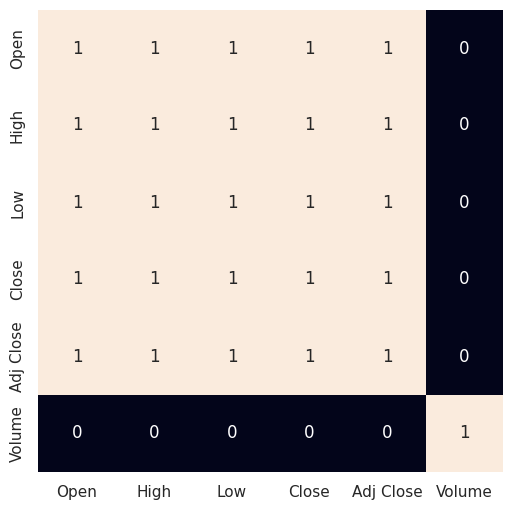

In [ ]:
# Korelasyon matrisi oluşturma ,Veri setindeki sayısal değişkenler arasındaki ilişkiyi incelemek için korelasyon analizini kullanılır
plt.figure(figsize=(6,6))
sns.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

* Open, High, Low, Close ve Adj Close değişkenleri arasında mükemmel pozitif
korelasyon olduğu görülmektedir. Bu, bu değişkenlerin neredeyse aynı bilgiyi taşıdığını ve birbirleriyle çok yüksek oranda ilişkili olduğunu gösterir.
* Volume(İşlem hacmi) değişkeni, diğer tüm değişkenlerle hiçbir korelasyon göstermemektedir. Bu, hacmin diğer fiyat hareketleriyle bağımsız olabileceği ve fiyat hareketlerini tahmin etmek için tek başına kullanılamayabileceğini gösterir.

**3. Outlier Değerlerin tespiti**

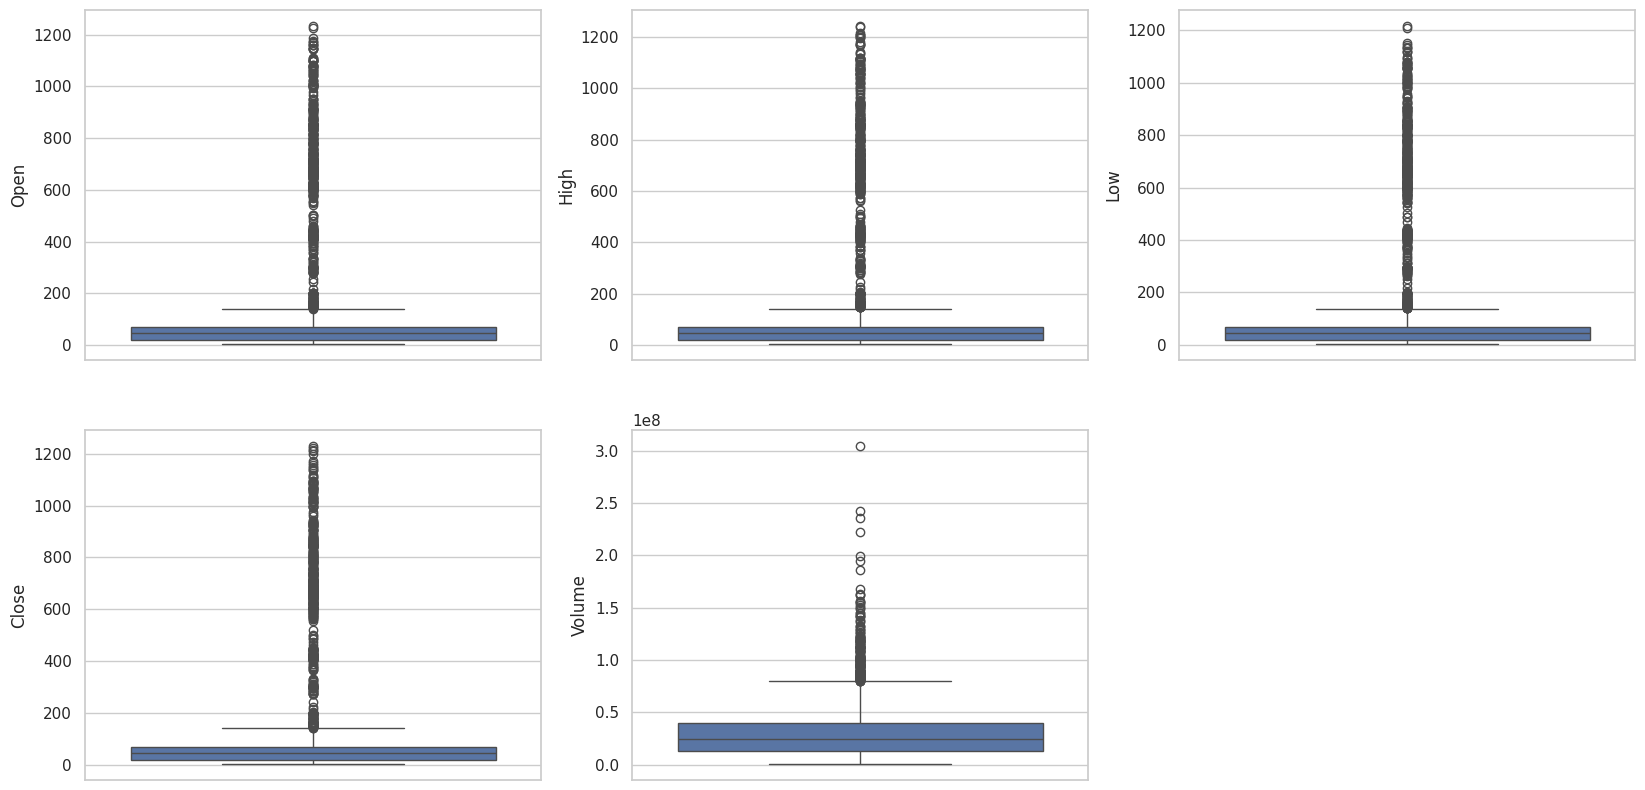

In [ ]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(df[col])
plt.show()

## **Data Pre-processing**



*   Gereksiz Sütunların Silinmesi
*   Özellik Çıkarımı
*   Zaman Serisi Analizi
*   Kategorik Verilerin İşlenmesi
*   Normalizasyon
*   Split Dataset









***Gereksiz sütunların silinmesi***

In [ ]:
 df = df.drop(['Adj Close'], axis=1)

### **Feature Engineering**
Mevcut olanlardan bazı değerli özellikler türetmeye yardımcı olur. Bu ekstra özellikler bazen modelin performansını önemli ölçüde artırmaya yardımcı olur ve kesinlikle veriler hakkında daha derin içgörüler elde etmeye yardımcı olur.


In [ ]:
# Tarih sütununu datetime tipine dönüştürme
df['Date'] = pd.to_datetime(df['Date'])

# Haftanın gününü yeni bir sütuna ekleme Haftanın günü (0: Pazartesi, 6: Pazar)
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Ayı yeni bir sütuna ekleme
df['Month'] = df['Date'].dt.month

# Yılı yeni bir sütuna ekleme
df['Year'] = df['Date'].dt.year

# Çeyreği yeni bir sütuna ekleme
df['Quarter'] = df['Date'].dt.quarter

df.head(10)

,Date,Open,High,Low,Close,Volume,DayOfWeek,Month,Year,Quarter
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,1,6,2010,2
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,2,6,2010,2
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,3,7,2010,3
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,4,7,2010,3
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,1,7,2010,3
5,2010-07-07,3.280,3.326,2.996,3.160,34608500,2,7,2010,3
6,2010-07-08,3.228,3.504,3.114,3.492,38557000,3,7,2010,3
7,2010-07-09,3.516,3.580,3.310,3.480,20253000,4,7,2010,3
8,2010-07-12,3.590,3.614,3.400,3.410,11012500,0,7,2010,3
9,2010-07-13,3.478,3.728,3.380,3.628,13400500,1,7,2010,3


1. Çeyrek (Q1): Ocak, Şubat, Mart
2. Çeyrek (Q2): Nisan, Mayıs, Haziran
3. Çeyrek (Q3): Temmuz, Ağustos, Eylül
4. Çeyrek (Q4): Ekim, Kasım, Aralık

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2956 non-null   datetime64[ns]
 1   Open       2956 non-null   float64       
 2   High       2956 non-null   float64       
 3   Low        2956 non-null   float64       
 4   Close      2956 non-null   float64       
 5   Volume     2956 non-null   int64         
 6   DayOfWeek  2956 non-null   int32         
 7   Month      2956 non-null   int32         
 8   Year       2956 non-null   int32         
 9   Quarter    2956 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(4), int64(1)
memory usage: 184.9 KB


#### **Zaman Serisi Analizi**

*   Yıllık analiz
* Aylık ortalama kapanış Fiyatları Hesaplama ve Görselleştirme
*   Çeyreklik Ortalama Kapanış Fiyatları Hesaplama ve Görselleştirme
*   Mevsimsel Analiz
*   Günlük analiz





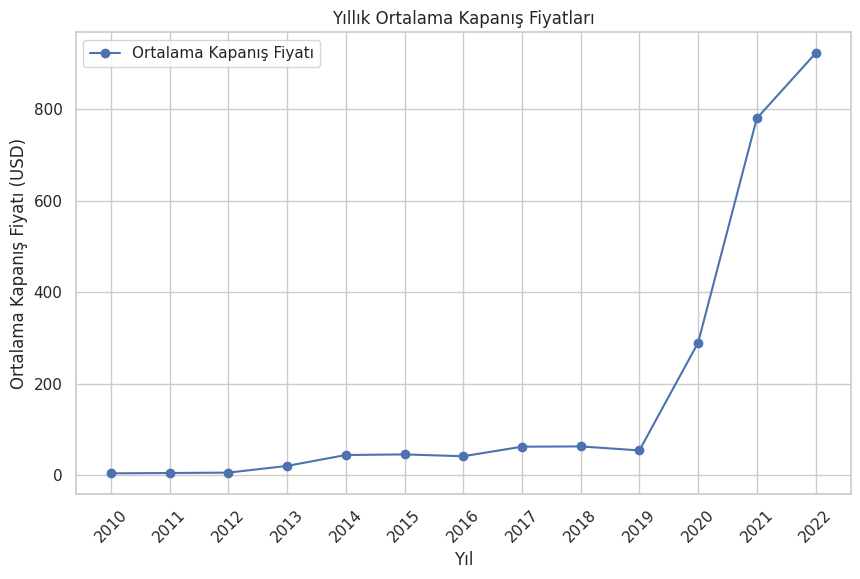

In [ ]:
# Yıllık ortalama kapanış fiyatını hesaplama
yearly_avg = df.groupby('Year')['Close'].mean()

# Yıllık ortalamaları görselleştirme
plt.figure(figsize=(10, 6))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linestyle='-', color='b', label='Ortalama Kapanış Fiyatı')
plt.title('Yıllık Ortalama Kapanış Fiyatları')
plt.xlabel('Yıl')
plt.ylabel('Ortalama Kapanış Fiyatı (USD)')
plt.grid(True)
plt.legend()
plt.xticks(yearly_avg.index, rotation=45)
plt.show()

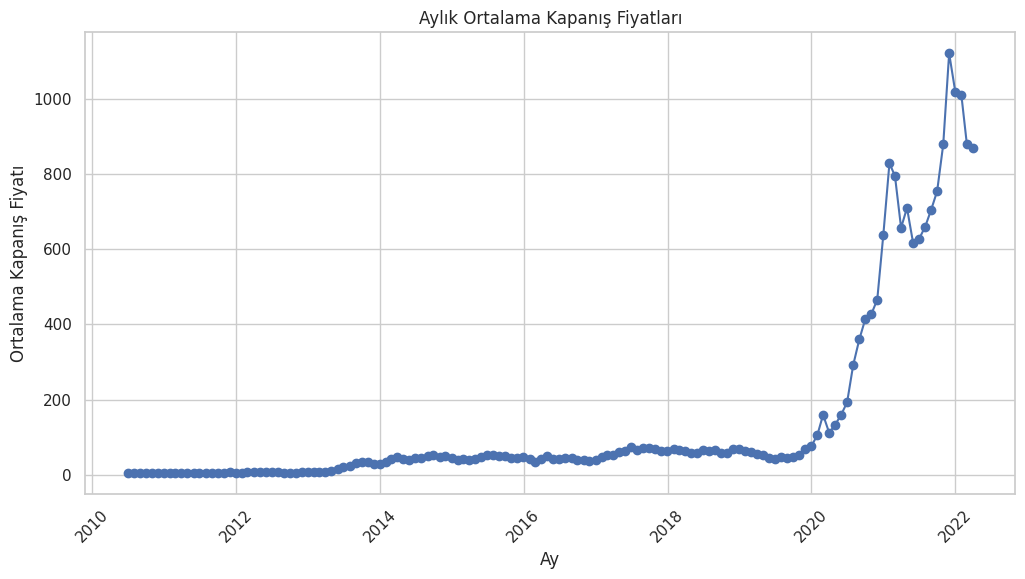

In [ ]:
# Aylık ortalama kapanış fiyatını hesapla
monthly_avg = df.resample('M', on='Date')['Close'].mean()

# Aylık ortalama kapanış fiyatlarını görselleştir
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='b',)
plt.title('Aylık Ortalama Kapanış Fiyatları')
plt.xlabel('Ay')
plt.ylabel('Ortalama Kapanış Fiyatı')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


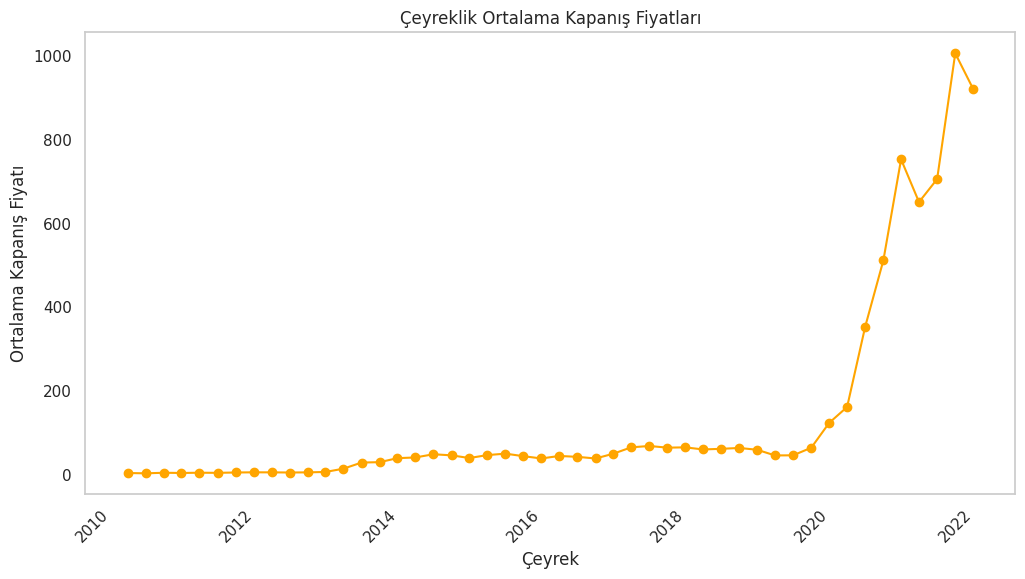

In [ ]:
# Çeyreklik ortalama kapanış fiyatını hesapla
# Veriyi her 3 aylık dönemde gruplar ve ortalama kapanış fiyatlarını çizer.
quarterly_avg = df.resample('Q', on='Date')['Close'].mean()

# Çeyreklik ortalama kapanış fiyatlarını görselleştir
plt.figure(figsize=(12, 6))
plt.plot(quarterly_avg.index, quarterly_avg.values, marker='o', color='orange')
plt.title('Çeyreklik Ortalama Kapanış Fiyatları')
plt.xlabel('Çeyrek')
plt.ylabel('Ortalama Kapanış Fiyatı')
plt.xticks(rotation=45)
plt.grid()
plt.show()

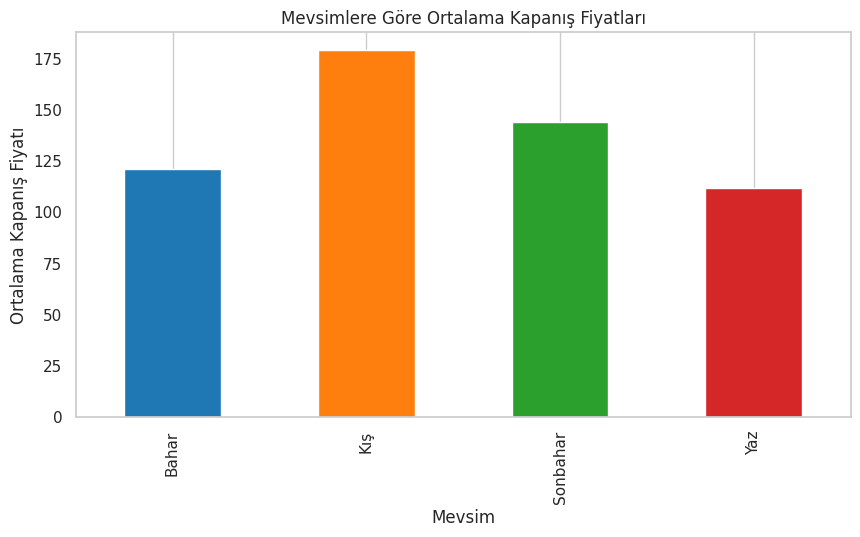

In [ ]:
# Mevsimleri belirle
def get_season(month):
    if month in [12, 1, 2]:
        return 'Kış'
    elif month in [3, 4, 5]:
        return 'Bahar'
    elif month in [6, 7, 8]:
        return 'Yaz'
    else:
        return 'Sonbahar'

# Yeni sütun ekle
df['Season'] = df['Month'].apply(get_season)

# Mevsimlere göre ortalama kapanış fiyatlarını hesapla
seasonal_avg = df.groupby('Season')['Close'].mean().sort_index()

# Sezon ortalamalarını görselleştir
plt.figure(figsize=(10, 5))
seasonal_avg.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Mevsimlere Göre Ortalama Kapanış Fiyatları')
plt.xlabel('Mevsim')
plt.ylabel('Ortalama Kapanış Fiyatı')
plt.grid(axis='y')
plt.show()

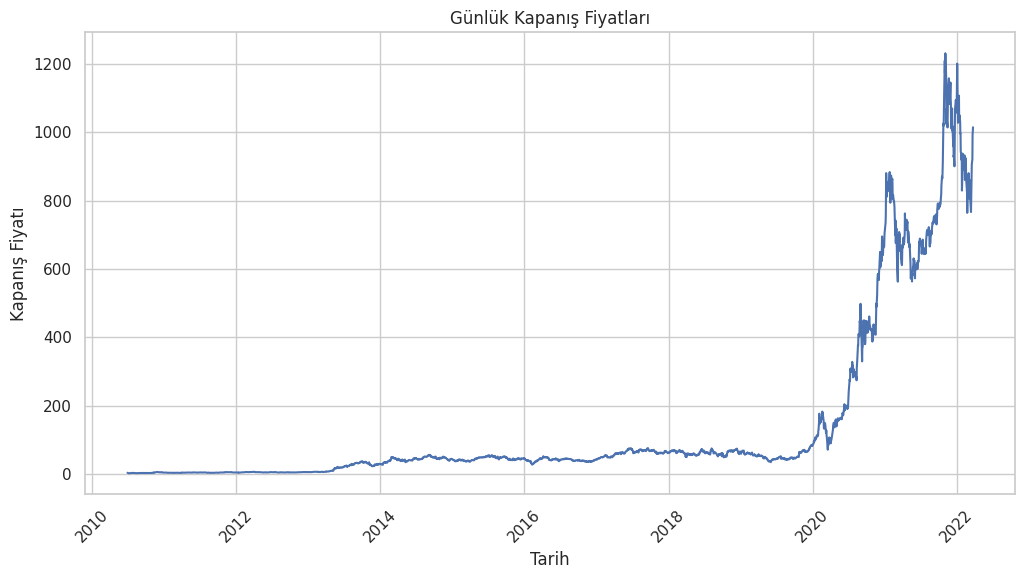

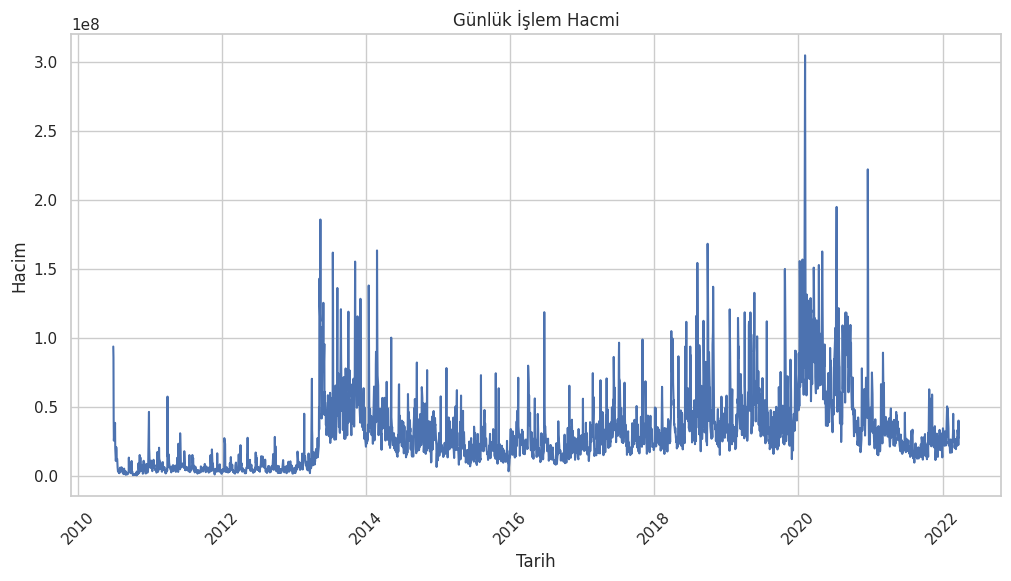

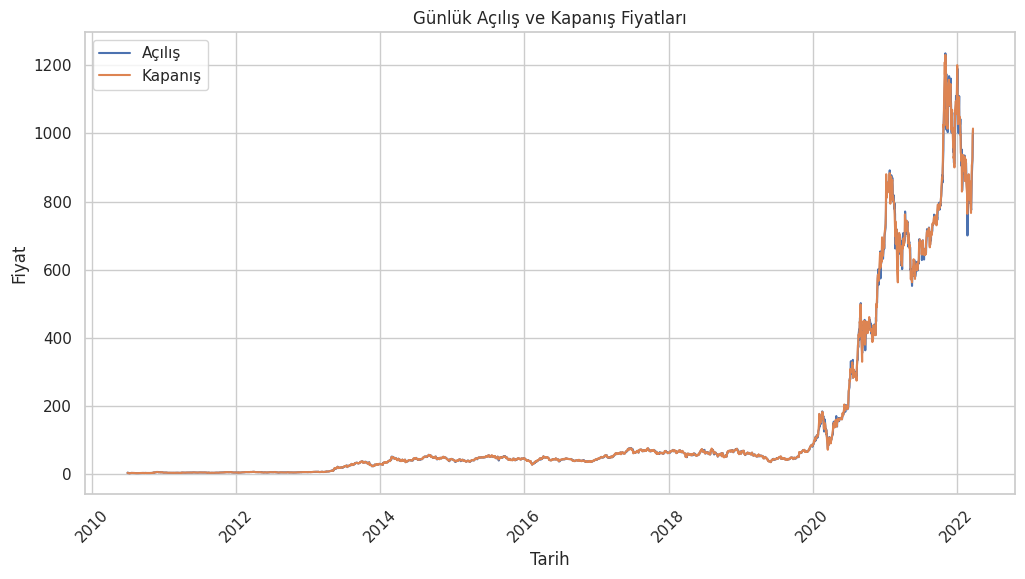

In [ ]:
# Günlük kapanış fiyatlarını görselleştirme
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close', data=df)
plt.title('Günlük Kapanış Fiyatları')
plt.xlabel('Tarih')
plt.ylabel('Kapanış Fiyatı')
plt.xticks(rotation=45)
plt.show()

# Günlük işlem hacmini görselleştirme
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Volume', data=df)
plt.title('Günlük İşlem Hacmi')
plt.xlabel('Tarih')
plt.ylabel('Hacim')
plt.xticks(rotation=45)
plt.show()

# Günlük açılış ve kapanış fiyatlarını karşılaştırma
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Open', data=df, label='Açılış')
sns.lineplot(x='Date', y='Close', data=df, label='Kapanış')
plt.title('Günlük Açılış ve Kapanış Fiyatları')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Yeni özelliklerin eklenmesi
- **open-close** Anlamı: Eğer bu fark pozitifse, hisse senedi açılıştan kapanışa
kadar değer kaybetmiştir (çünkü açılış fiyatı kapanış fiyatından yüksektir). Eğer negatifse, hisse senedi gün içinde değer kazanmıştır (çünkü kapanış fiyatı açılış fiyatından yüksektir).
- **target**->Anlamı: Eğer ertesi günün kapanış fiyatı bugünkünden yüksekse (yani hisse senedi değeri artmışsa), bu günü "kazanma" olarak işaretler (target = 1). Aksi durumda, "kaybetme" (target = 0) olarak işaretler.
- **low-high** Anlamı: Bu fark genellikle negatif olacaktır, çünkü en düşük fiyat her zaman en yüksek fiyattan daha küçüktür. Bu sütun, o gün içindeki fiyat dalgalanmasını veya oynaklığı gösterir.

In [ ]:
# Feature Extraction - Yeni özelliklerin eklenmesi
df['open-close'] = df['Open'] - df['Close']  # Açılış ve kapanış fiyatları arasındaki fark
df['low-high'] = df['Low'] - df['High']      # En düşük ve en yüksek fiyatlar arasındaki fark
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)  # Ertesi gün kapanış fiyatına dayalı hedef


# Sonuçlar
print(df[['open-close', 'low-high', 'target']].head())


   open-close  low-high  target
0      -0.978    -1.492       0
1       0.392    -1.424       0
2       0.608    -1.130       0
3       0.760    -0.878       0
4       0.778    -0.834       0


Satın almanın veya almamanın bir sinyali olan hedef özelliğini ekledik, modelimizi bunu tahmin edecek şekilde eğiteceğiz.Pasta grafiği kullanarak hedefin dengeli olup olmadığını kontrol edelim .

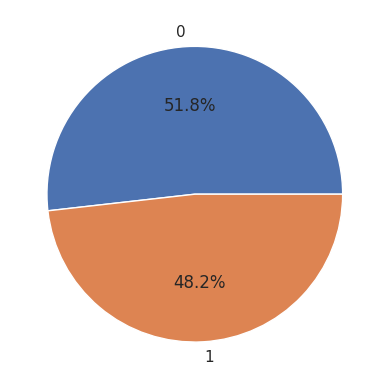

In [ ]:
plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()


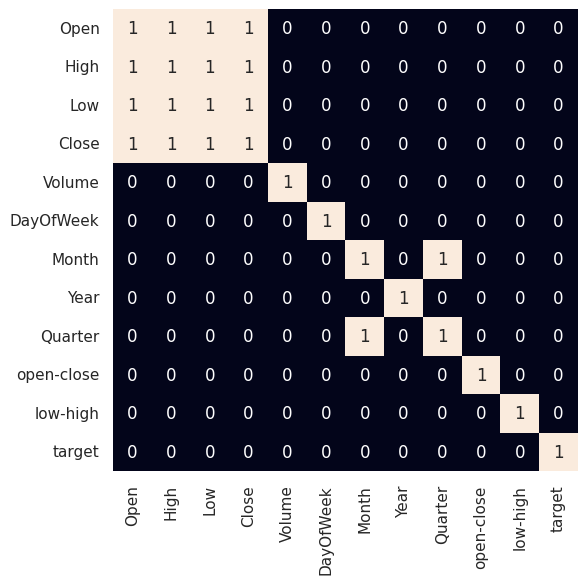

In [ ]:
numeric_df = df.select_dtypes(include=np.number)

plt.figure(figsize=(6, 6))
sns.heatmap(numeric_df.corr() > 0.9, annot=True, cbar=False)
plt.show()

# This code is modified by Susobhan Akhuli





In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,DayOfWeek,Month,Year,Quarter,Season,open-close,low-high,target
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,1,6,2010,2,Yaz,-0.978,-1.492,0
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,2,6,2010,2,Yaz,0.392,-1.424,0
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,3,7,2010,3,Yaz,0.608,-1.130,0
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,4,7,2010,3,Yaz,0.760,-0.878,0
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,1,7,2010,3,Yaz,0.778,-0.834,0


### Kategorik Verilerin İşlenmesi


*   Season Sütunu İçin One-Hot Encoding:



In [ ]:
df = pd.get_dummies(df, columns=['Season'], drop_first=True)
df.head()

,Date,Open,High,Low,Close,Volume,DayOfWeek,Month,Year,Quarter,open-close,low-high,target,Season_Kış,Season_Sonbahar,Season_Yaz
0,2010-06-29,3.800,5.000,3.508,4.778,93831500,1,6,2010,2,-0.978,-1.492,0,False,False,True
1,2010-06-30,5.158,6.084,4.660,4.766,85935500,2,6,2010,2,0.392,-1.424,0,False,False,True
2,2010-07-01,5.000,5.184,4.054,4.392,41094000,3,7,2010,3,0.608,-1.130,0,False,False,True
3,2010-07-02,4.600,4.620,3.742,3.840,25699000,4,7,2010,3,0.760,-0.878,0,False,False,True
4,2010-07-06,4.000,4.000,3.166,3.222,34334500,1,7,2010,3,0.778,-0.834,0,False,False,True


### Veri Ölçekleme (Normalization/Standardization)
Sayısal özellikler

In [ ]:
scaler = StandardScaler()
numeric_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'open-close', 'low-high']
df[numeric_features] = scaler.fit_transform(df[numeric_features])
df.head()

,Date,Open,High,Low,Close,Volume,DayOfWeek,Month,Year,Quarter,open-close,low-high,target,Season_Kış,Season_Sonbahar,Season_Yaz
0,2010-06-29,-0.539560,-0.534640,-0.541240,-0.535764,2.234419,1,6,2010,2,-0.093455,0.346144,0,False,False,True
1,2010-06-30,-0.534128,-0.530403,-0.536513,-0.535812,1.952208,2,6,2010,2,0.047689,0.350993,0,False,False,True
2,2010-07-01,-0.534760,-0.533921,-0.539000,-0.537307,0.349529,3,7,2010,3,0.069942,0.371960,0,False,False,True
3,2010-07-02,-0.536360,-0.536126,-0.540280,-0.539514,-0.200703,4,7,2010,3,0.085602,0.389932,0,False,False,True
4,2010-07-06,-0.538760,-0.538549,-0.542643,-0.541986,0.107938,1,7,2010,3,0.087456,0.393070,0,False,False,True


### Veri Setini Eğitim ve Test Olarak Bölme
Verinin %80'ini eğitim seti, %20'sini ise test seti olarak ayrılması

In [ ]:
X = df[['Open', 'High', 'Low', 'Volume', 'open-close', 'low-high', 'DayOfWeek', 'Month', 'Year', 'Quarter','Season_Kış', 'Season_Sonbahar',	'Season_Yaz']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(2364, 13) (592, 13)


## **Model Development and Evaluation**
* **Lojistik Regresyon (Logistic Regression):** Basit ve hızlı bir modeldir, ikili sınıflandırma için çok uygundur.
* **Destek Vektör Makinesi (SVM):** Verilerin ayrılabilirliğini bulmaya çalışır ve genellikle sınıflandırma için güçlü bir modeldir.
    * SVC(kernel='rbf', probability=True): Radial Basis Function kernel kullanan, olasılık tahmin yeteneğine sahip bir Destek Vektör Makineleri (SVM) modeli.

* **Random Forest:**  Karar ağaçlarının birleşimidir ve genellikle sınıflandırma ve regresyon problemleri için oldukça etkilidir.
* **XGBoost:** Daha hızlı ve güçlü bir ağaç tabanlı algoritmadır. Büyük veri setleri ve zaman serisi tahmini gibi durumlar için oldukça etkilidir.
* **ROC-AUC (Receiver Operating Characteristic - Area Under the Curve):** İkili sınıflandırma problemlerinde modelin performansını değerlendirmek için kullanılan bir metriktir. Modelin pozitif ve negatif örnekleri ne kadar iyi ayırt ettiğini gösterir.
  * **Training ROC-AUC:** Modelin eğitim verilerindeki performansını gösterir.
  * **Validation ROC-AUC:** Modelin test verilerindeki (görmediği veriler) performansını gösterir ve modelin genelleme yeteneği hakkında bilgi verir.
* **Doğruluk (Accuracy):** Model tahminlerinin ne kadar doğru olduğunu gösterir.  
    * Basit bir metriktir ve kolay anlaşılır.Ancak, dengesiz veri setlerinde yanıltıcı olabilir. Sınıfların dengeli olduğu ve tüm sınıfların eşit öneme sahip olduğu durumlarda kullanılabilir.
* **Classification Report (Sınıflandırma Raporu):**
  * Sınıf bazında performansı incelemek için kullanılır.
  * **F1 Skoru**, Precision ve recall'ın harmonik ortalamasıdır ve modelin genel performansını dengeli bir şekilde değerlendirmek için kullanılır.
  * **Precision(Kesinlik)**, Pozitif olarak tahmin edilen örneklerin kaçının gerçekten pozitif olduğunu gösterir.
  * **Recall(Duyarlılık)**,Gerçekten pozitif olan örneklerin kaçının doğru olarak pozitif tahmin edildiğini gösterir.

Lojistik Regresyon:
Training ROC-AUC: 0.5244
Validation ROC-AUC: 0.4364
Accuracy: 0.4645
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.18      0.25       292
           1       0.48      0.74      0.58       300

    accuracy                           0.46       592
   macro avg       0.44      0.46      0.42       592
weighted avg       0.44      0.46      0.42       592


-------------------------------------------------------------
Random Forest:
Training ROC-AUC: 1.0000
Validation ROC-AUC: 0.4619
Accuracy: 0.4730
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       292
           1       0.48      0.53      0.50       300

    accuracy                           0.47       592
   macro avg       0.47      0.47      0.47       592
weighted avg       0.47      0.47      0.47       592


-------------------------------------------------------------
S

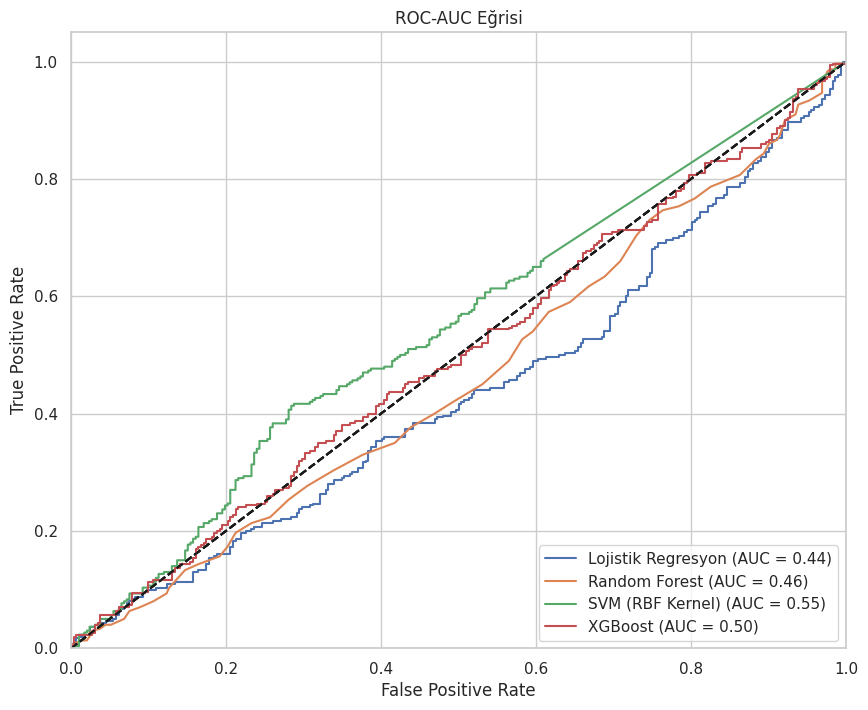

In [ ]:
# Modelleri tanımlanması
models = [
    ('Lojistik Regresyon', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM (RBF Kernel)', SVC(kernel='rbf', probability=True)),
    ('XGBoost', XGBClassifier())
]
# ROC eğrilerini çizmek için bir fonksiyon
def plot_roc_curve(fpr, tpr, model_name, roc_auc):
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Rastgele sınıflandırma çizgisi
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Eğrisi")
    plt.legend(loc="lower right")

plt.figure(figsize=(10, 8))  # ROC-AUC grafiği için boyut

# Her bir model için döngü
for model_name, model in models:
    # Modeli eğitme
    model.fit(X_train, y_train)

    # Eğitim setindeki ROC-AUC skoru
    train_pred_prob = model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, train_pred_prob)

    # Test setindeki ROC-AUC skoru
    test_pred_prob = model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, test_pred_prob)

    # ROC eğrisini hesaplama
    fpr, tpr, _ = roc_curve(y_test, test_pred_prob)

    # ROC eğrisini çizme
    plot_roc_curve(fpr, tpr, model_name, test_roc_auc)

    # Accuracy ve Classification Report
    test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, test_pred)
    class_report = classification_report(y_test, test_pred)

    # Sonuçları yazdırma
    print(f'{model_name}:')
    print(f'Training ROC-AUC: {train_roc_auc:.4f}')
    print(f'Validation ROC-AUC: {test_roc_auc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Classification Report:\n{class_report}')
    print()
    print("-------------------------------------------------------------")

# ROC-AUC grafiğini gösterme
plt.show()

**ROC-AUC eğrisi,** bir sınıflandırma modelinin performansını değerlendirmek için kullanılan önemli bir grafiktir. Bu grafikte, modelin doğru pozitif oranı (True Positive Rate, TPR) ile yanlış pozitif oranı (False Positive Rate, FPR) arasındaki ilişki gösterilir. AUC (Area Under the Curve) değeri ise bu eğrinin altındaki alanı ifade eder ve modelin genel performansını özetler.
* ROC eğrisinin sol üst köşesine ne kadar yakınsa model o kadar iyidir. Bu,
modelin hem doğru pozitifleri doğru bir şekilde sınıflandırdığını hem de yanlış pozitifleri en aza indirdiğini gösterir.

**Grafiğin Analizi**
  * Eksenler:

    - X ekseni (False Positive Rate): Modelin yanlış pozitif sınıflandırdığı örneklerin oranını gösterir.
    - Y ekseni (True Positive Rate): Modelin doğru pozitif sınıflandırdığı örneklerin oranını gösterir.
    - Eğriler: Her bir eğri, farklı bir sınıflandırma modelinin performansını temsil eder.

  * Lojistik Regresyon: En düşük AUC değerine sahip modeldir. Bu, modelin diğer modellere göre daha düşük bir sınıflandırma performansı gösterdiğini ifade eder.
  * Random Forest: Lojistik regresyondan biraz daha iyi bir performans gösterir.
  * SVM (RBF Kernel): Tüm modeller arasında en yüksek AUC değerine sahip modeldir. Bu, modelin diğer modellere göre daha iyi bir sınıflandırma performansı gösterdiğini ifade eder.
  * XGBoost: SVM'den biraz daha düşük bir performansa sahiptir.

## Model Comparison


### **Analiz**

* **Lojistik Regresyon:** Training ROC-AUC değeri 0.52 ile en düşük seviyede. Validation ROC-AUC ve accuracy skorları da oldukça düşük.
* **Random Forest:** Eğitimde aşırıya kaçmış bir öğrenme var (ROC-AUC: 1.0). Ancak, validation ROC-AUC değeri oldukça düşük, doğrulamada beklenenden daha kötü sonuç veriyor.
* **SVM (RBF Kernel):** Validation ROC-AUC skoru en yüksek (0.5456). Özellikle sınıf 0 için precision ve recall değerlerinin 0 olması, modelin bu sınıfı tamamen tanımadığını ve dolayısıyla başarısız olduğunu gösteriyor.
* **XGBoost:** ROC-AUC ve accuracy değerleri dengeli. Validation ROC-AUC 0.50 civarında, her iki sınıfı da yaklaşık eşit başarıyla tahmin ediyor.

Genel olarak, modellerin doğruluğu %50'nin biraz üzerinde ya da altında, yani şu anki haliyle modellerin tahminlerinin yönü güvenilir değil.

### **Öneri**:
* **SVM** validation setinde en iyi performansı gösteriyor. Ancak sınıf 0 için kötü tahminler yaptığından, dengelemek için daha fazla ince ayar yapılabilir.
* **XGBoost** ROC-AUC ve accuracy açısından dengeli sonuçlar verdiği için, üzerinde daha fazla optimizasyon denenebilir.
* **Random Forest** aşırı öğrenme sorunu
yaşıyor olabilir, bu model için parametre ayarlarıyla düzenlemeler yapılmalı.

## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hiperparametre arama için grid
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
      'n_estimators': [50, 100, 200],
     'max_depth': [None, 5, 10],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}

param_grid_svm = {
      'C': [0.1, 1, 10, 100],
     'gamma': [0.001, 0.01, 0.1, 1],
     'kernel': ['rbf']
}

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV kullanımı
grid_searches = [
    ('Lojistik Regresyon', GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)),
    ('Random Forest', GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)),
    ('SVM', GridSearchCV(SVC(probability=True), param_grid_svm, cv=5)),
    ('XGBoost', GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5)),
]

# En iyi modeli ve performansını yazdırma
for model_name, grid_search in grid_searches:
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Training ROC-AUC
    train_pred_prob = best_model.predict_proba(X_train)[:, 1]
    train_roc_auc = roc_auc_score(y_train, train_pred_prob)

    # Test ROC-AUC
    test_pred_prob = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, test_pred_prob)

    # Accuracy ve Classification Report
    test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, test_pred)
    class_report = classification_report(y_test, test_pred)

    print(f'{model_name} (Best Parameters: {grid_search.best_params_}):')
    print(f'Training ROC-AUC: {train_roc_auc:.4f}')
    print(f'Validation ROC-AUC: {test_roc_auc:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Classification Report:\n{class_report}')
    print()
    print("-------------------------------------------------------------")

Lojistik Regresyon (Best Parameters: {'C': 0.1, 'solver': 'liblinear'}):
Training ROC-AUC: 0.5239
Validation ROC-AUC: 0.4507
Accuracy: 0.4713
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.16      0.23       292
           1       0.49      0.77      0.60       300

    accuracy                           0.47       592
   macro avg       0.45      0.47      0.42       592
weighted avg       0.45      0.47      0.42       592


-------------------------------------------------------------
Random Forest (Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50}):
Training ROC-AUC: 0.7572
Validation ROC-AUC: 0.4519
Accuracy: 0.4848
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.24      0.31       292
           1       0.49      0.72      0.59       300

    accuracy                           0.48       592
   macro avg     

### Hiperparametre optimizasyonu öncesi ve sonrası sonuçları karşılaştırabileceğimiz tablo
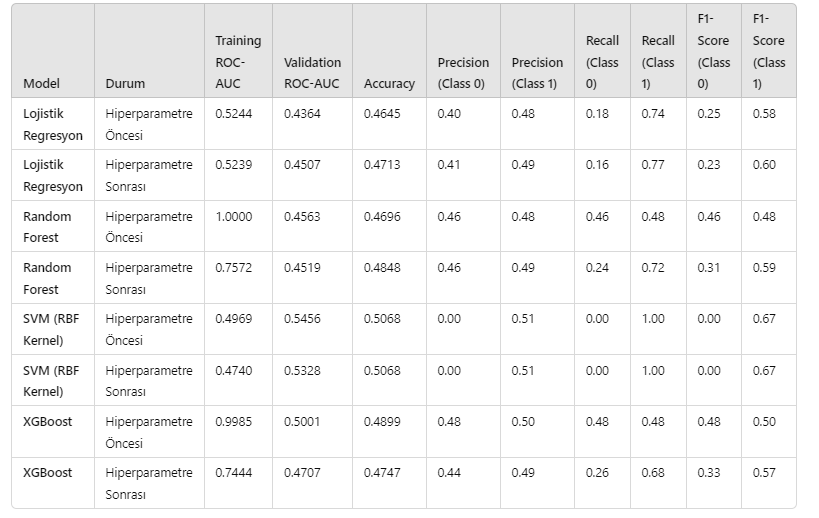

## Genel Değerlendirme:
* Modellerin çoğunda hiperparametre optimizasyonu, aşırı öğrenmeyi azaltmış ve performansı biraz iyileştirmiş. Ancak ROC-AUC ve doğruluk değerlerine baktığımızda, modellerin hala yeterince iyi performans göstermediğini söyleyebiliriz.
* Özellikle, 0. sınıfın (örneğin fiyat düşüşü tahmini) performansı oldukça düşük ve bu da genel performansı olumsuz etkiliyor.
* Model seçimi ve verilerin yeniden işlenmesi konusunda daha farklı yaklaşımlar denemek gerekebilir.Örneğin, daha fazla özellik mühendisliği yapmak,PCA algoritmasını kullanarak önemli sütunları belirleyip modeli eğitmek ya da daha farklı model mimarilerine (derin öğrenme gibi LSTM) yönelmek gerekebilir.